
# Random Forests in Python – A Simple, Step‑by‑Step Guide

In this notebook we will **build intuition** for Random Forests and then **implement them in Python** using `scikit-learn` 

1. Load or create Data
2. Explore the data with basic EDA and visualizations  
3. Train a **single Decision Tree** (our baseline)  
4. Understand the **theory and formulas** behind Random Forests  
5. Train a **Random Forest classifier**  
6. Compare performance: tree vs forest  
7. Visualize **feature importance** and **number-of-trees vs accuracy**



In [1]:

# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report



### 1. Intuition: From a Single Tree to a Forest 🌳🌳🌳

A **Decision Tree** is like a flowchart of yes/no questions that splits data into smaller and smaller groups.

- Trees are **easy to understand**, but  
- A single tree can **overfit** (memorize noise in the training data).

### Idea of a Random Forest

A **Random Forest** builds **many decision trees** and combines them.

1. **Bootstrap sampling (Bagging)**  
   - We create many different training sets by sampling with replacement from the original data.  
   - For each tree \( m \), we draw a bootstrap sample \( D_m \) from the training data.

2. **Random feature subsets**  
   - At each split, instead of looking at all features, each tree only looks at a **random subset** of features.

3. **Voting (for classification)**  
   - Each tree makes a prediction \( h_m(x) \).  
   - The Random Forest prediction is the **majority vote**:

\[
\hat{y} = \text{mode}\left( h_1(x), h_2(x), \dots, h_M(x) \right)
\]

For regression, we take the **average** of the tree predictions:

\[
\hat{y} = \frac{1}{M} \sum_{m=1}^{M} h_m(x)
\]

### Why does this help?

- Each tree is **different** (due to random data and random features).  
- Individual trees may be **weak** and noisy.  
- But if many weak models agree, their **average** is usually **strong and stable**.

This is called an **ensemble method**.



## 2. Generate a Simple Synthetic Dataset

We will create a **2-class classification** dataset with a few numerical features using `make_classification`.


In [2]:

# Reproducibility
np.random.seed(42)

# Generate synthetic classification dataset
X, y = make_classification(
    n_samples=1000,
    n_features=6,
    n_informative=3,
    n_redundant=1,
    n_repeated=0,
    n_classes=2,
    n_clusters_per_class=2,
    class_sep=1.2,
    random_state=42
)

feature_names = [f"feature_{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df["target"] = y

df.head()


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target
0,1.271222,0.151687,-0.997675,2.313371,1.036647,-1.838728,0
1,0.866027,-0.432364,1.370410,2.396052,1.429458,-1.675681,0
2,-1.632405,2.428371,1.208932,0.020318,-0.661493,3.095891,1
3,0.014137,-1.689321,0.339724,0.683729,0.282003,-0.987486,0
4,1.164647,-0.703380,0.192560,-0.953699,1.144760,-1.517453,0



## 3. Quick EDA (Exploratory Data Analysis)

We'll keep it very simple:

- View first few rows  
- Summary statistics  
- Class balance  
- Distributions of a couple of features


In [3]:

# First 5 rows
df.head()


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target
0,1.271222,0.151687,-0.997675,2.313371,1.036647,-1.838728,0
1,0.866027,-0.432364,1.370410,2.396052,1.429458,-1.675681,0
2,-1.632405,2.428371,1.208932,0.020318,-0.661493,3.095891,1
3,0.014137,-1.689321,0.339724,0.683729,0.282003,-0.987486,0
4,1.164647,-0.703380,0.192560,-0.953699,1.144760,-1.517453,0


In [4]:

# Summary statistics
df.describe()


,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,target
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.427697,0.009486,-0.000490,0.582060,-0.001919,-0.601864,0.503000
std,1.118296,1.360954,0.987576,1.401308,0.985892,1.371329,0.500241
min,-3.281584,-4.150596,-3.275011,-3.978978,-2.899894,-4.037231,0.000000
25%,-0.315409,-1.153959,-0.676801,-0.146559,-0.651529,-1.508776,0.000000
50%,0.461879,0.232133,-0.030627,0.788009,-0.043557,-0.911253,1.000000
75%,1.128493,1.145834,0.658299,1.570081,0.680497,0.270996,1.000000
max,3.711145,3.060860,3.014712,4.041188,2.765980,4.819524,1.000000


In [5]:

# Class balance
df["target"].value_counts(normalize=True)


target
1    0.503
0    0.497
Name: proportion, dtype: float64

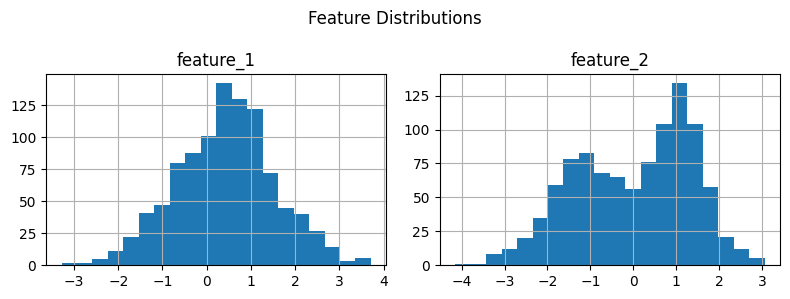

In [6]:

# Histograms for a couple of features
columns_to_plot = ["feature_1", "feature_2"]

df[columns_to_plot].hist(bins=20, figsize=(8, 3))
plt.suptitle("Feature Distributions")
plt.tight_layout()
plt.show()



## 4. Train–Test Split

We split the data into:

- **Training set**: for learning the model  
- **Test set**: for evaluating on unseen data

We will use an 80–20 split.


In [7]:

X = df[feature_names].values
y = df["target"].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((800, 6), (200, 6))


## 5. Baseline: Single Decision Tree

Before we build a Random Forest, let's train one **DecisionTreeClassifier**.

### Gini Impurity (split criterion)

One common way to decide how to split a node is **Gini impurity**:

\[
G = 1 - \sum_{k=1}^{K} p_k^2
\]

where \( p_k \) is the proportion of class \( k \) in the node.

A **pure node** (only one class) has Gini \(= 0\).  
Decision Trees choose splits that **reduce impurity** the most.


In [8]:

# Train a single decision tree
tree_clf = DecisionTreeClassifier(
    max_depth=None,        # allow full growth (can overfit)
    random_state=42
)
tree_clf.fit(X_train, y_train)

# Predictions
y_train_pred_tree = tree_clf.predict(X_train)
y_test_pred_tree = tree_clf.predict(X_test)

# Accuracy
tree_train_acc = accuracy_score(y_train, y_train_pred_tree)
tree_test_acc = accuracy_score(y_test, y_test_pred_tree)

print(f"Decision Tree - Train accuracy: {tree_train_acc:.3f}")
print(f"Decision Tree - Test accuracy : {tree_test_acc:.3f}")


Decision Tree - Train accuracy: 1.000
Decision Tree - Test accuracy : 0.950


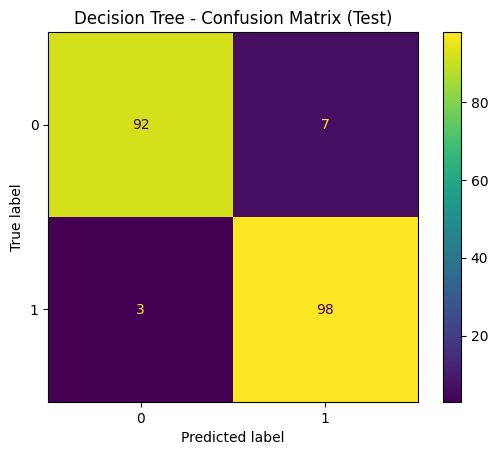


Classification report:
              precision    recall  f1-score   support

           0       0.97      0.93      0.95        99
           1       0.93      0.97      0.95       101

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



In [9]:

# Confusion matrix for the tree
cm_tree = confusion_matrix(y_test, y_test_pred_tree)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_tree)
disp.plot()
plt.title("Decision Tree - Confusion Matrix (Test)")
plt.show()

print("\nClassification report:")
print(classification_report(y_test, y_test_pred_tree))


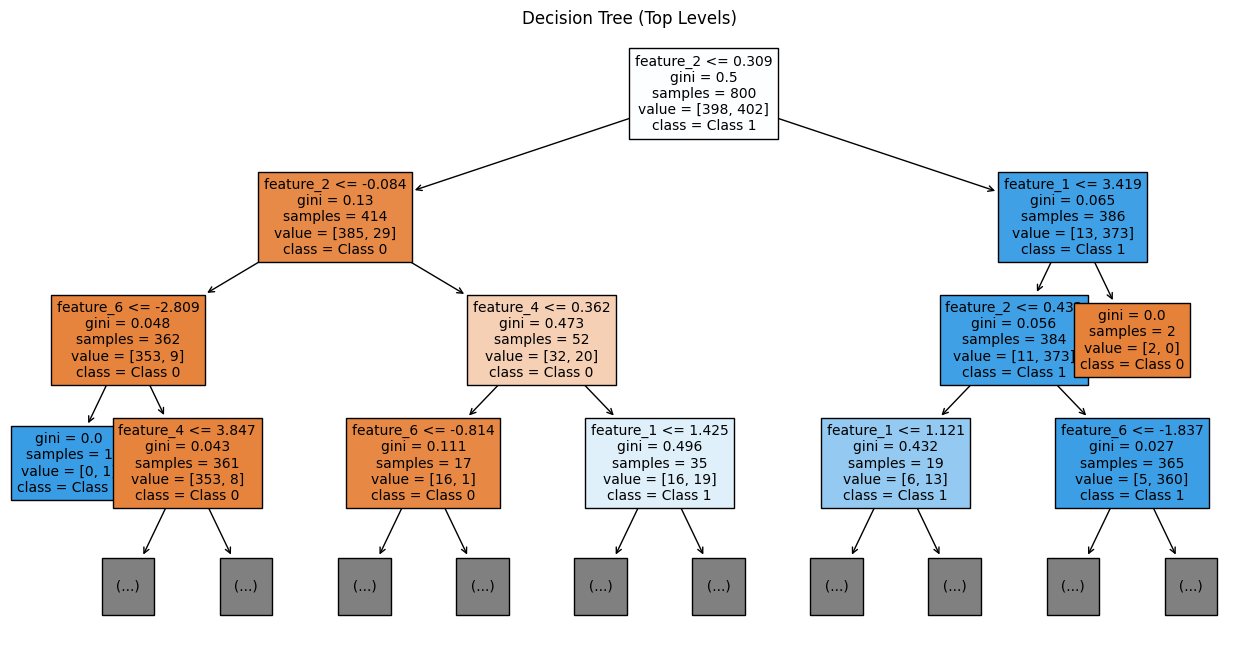

In [10]:

# Visualize the top levels of the tree
plt.figure(figsize=(16, 8))
plot_tree(
    tree_clf,
    feature_names=feature_names,
    class_names=["Class 0", "Class 1"],
    filled=True,
    max_depth=3,  # only show first few levels so it is readable
    fontsize=10
)
plt.title("Decision Tree (Top Levels)")
plt.show()



## 6. Random Forest Classifier

Now we train a **RandomForestClassifier**.

Key hyperparameters:

- `n_estimators`: number of trees in the forest (more trees → more stable, more compute)  
- `max_depth`: maximum depth of each tree (None = full growth)  
- `max_features`: number of features to consider at each split  
- `min_samples_split`: minimum samples needed to split an internal node  
- `random_state`: for reproducibility

We will start with a simple configuration and then inspect performance.


In [11]:

rf_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    max_features="sqrt",   # common choice for classification
    random_state=42,
    n_jobs=-1              # use all CPU cores
)

rf_clf.fit(X_train, y_train)

y_train_pred_rf = rf_clf.predict(X_train)
y_test_pred_rf = rf_clf.predict(X_test)

rf_train_acc = accuracy_score(y_train, y_train_pred_rf)
rf_test_acc = accuracy_score(y_test, y_test_pred_rf)

print(f"Random Forest - Train accuracy: {rf_train_acc:.3f}")
print(f"Random Forest - Test accuracy : {rf_test_acc:.3f}")


Random Forest - Train accuracy: 1.000
Random Forest - Test accuracy : 0.950


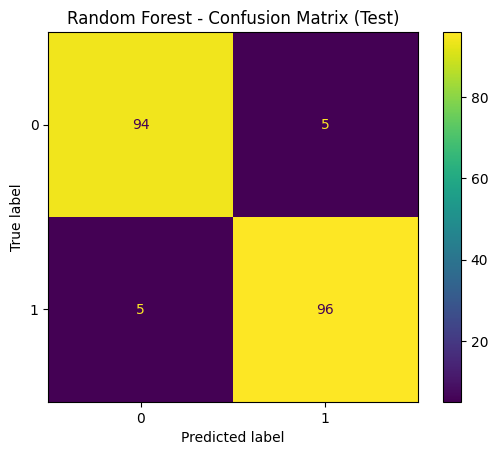


Classification report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        99
           1       0.95      0.95      0.95       101

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



In [12]:

# Confusion matrix for the random forest
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Random Forest - Confusion Matrix (Test)")
plt.show()

print("\nClassification report:")
print(classification_report(y_test, y_test_pred_rf))



## 7. Feature Importance

Random Forests can give us an estimate of **feature importance**:

- Each split that uses a feature reduces impurity.  
- We average that reduction over all trees.  
- Higher values → feature used more often and more effectively for splitting.


In [13]:

importances = rf_clf.feature_importances_
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values("importance", ascending=False)

importance_df


,feature,importance
1,feature_2,0.548385
5,feature_6,0.199538
3,feature_4,0.110675
0,feature_1,0.096806
2,feature_3,0.025218
4,feature_5,0.019378


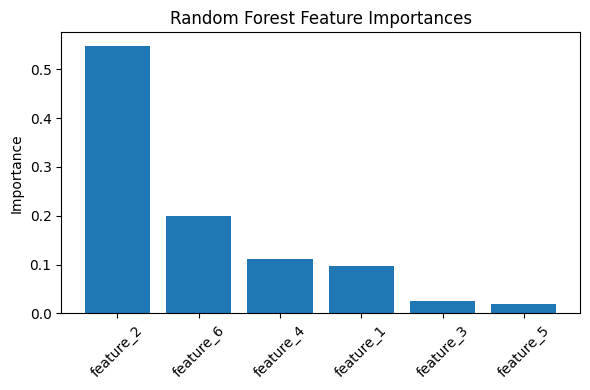

In [14]:

plt.figure(figsize=(6, 4))
plt.bar(importance_df["feature"], importance_df["importance"])
plt.xticks(rotation=45)
plt.ylabel("Importance")
plt.title("Random Forest Feature Importances")
plt.tight_layout()
plt.show()



## 8. How Does the Number of Trees Affect Performance?

One important question: **How many trees do we need?**

- Too few trees → model may be unstable.  
- More trees → more stable, but takes more time.

We'll train forests with different `n_estimators` and plot accuracy on train and test sets.


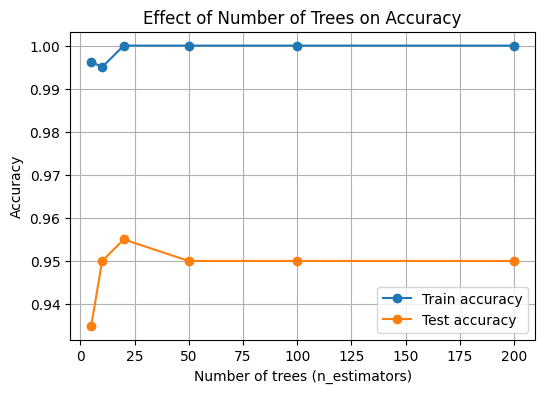

In [15]:

n_estimators_list = [5, 10, 20, 50, 100, 200]
train_acc_list = []
test_acc_list = []

for n in n_estimators_list:
    clf = RandomForestClassifier(
        n_estimators=n,
        max_depth=None,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1
    )
    clf.fit(X_train, y_train)
    train_acc_list.append(accuracy_score(y_train, clf.predict(X_train)))
    test_acc_list.append(accuracy_score(y_test, clf.predict(X_test)))

plt.figure(figsize=(6, 4))
plt.plot(n_estimators_list, train_acc_list, marker="o", label="Train accuracy")
plt.plot(n_estimators_list, test_acc_list, marker="o", label="Test accuracy")
plt.xlabel("Number of trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Effect of Number of Trees on Accuracy")
plt.legend()
plt.grid(True)
plt.show()



## 9. Visualizing the Decision Boundary (Just for Intuition)

To **see** what the model is doing, we'll:

- Take only 2 features (`feature_1` and `feature_2`)  
- Train a Random Forest on these 2D data  
- Plot the **decision boundary**.

This is only for intuition – in practice we use all useful features.


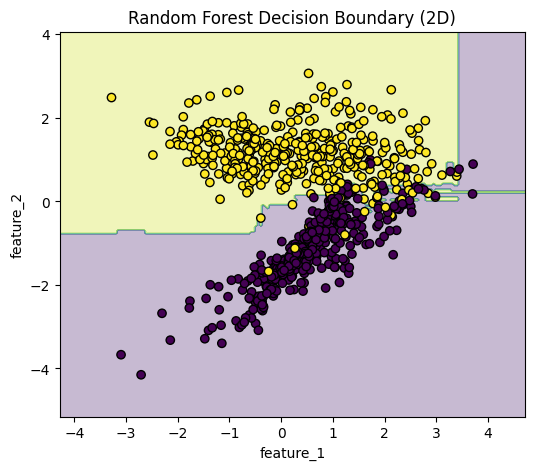

In [16]:

# Use only two features
X_2d = df[["feature_1", "feature_2"]].values
y_2d = df["target"].values

X2_train, X2_test, y2_train, y2_test = train_test_split(
    X_2d, y_2d, test_size=0.2, random_state=42, stratify=y_2d
)

rf_2d = RandomForestClassifier(
    n_estimators=100,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
rf_2d.fit(X2_train, y2_train)

# Create a grid of points
x_min, x_max = X_2d[:, 0].min() - 1, X_2d[:, 0].max() + 1
y_min, y_max = X_2d[:, 1].min() - 1, X_2d[:, 1].max() + 1
xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 200),
    np.linspace(y_min, y_max, 200)
)

Z = rf_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=(6, 5))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X2_train[:, 0], X2_train[:, 1], c=y2_train, edgecolor="k", marker="o")
plt.xlabel("feature_1")
plt.ylabel("feature_2")
plt.title("Random Forest Decision Boundary (2D)")
plt.show()



## 10. Summary

In this notebook, we:

- Built a **synthetic classification dataset**  
- Performed simple **EDA**  
- Trained a **single Decision Tree** and saw its performance  
- Understood the **Random Forest** idea:
  - Bootstrap samples
  - Random feature subsets
  - Majority voting
- Trained a **RandomForestClassifier** and compared it with a single tree  
- Looked at **feature importances**  
- Studied how **number of trees** affects accuracy  
- Visualized a **2D decision boundary** for intuition

Random Forests are:

- Powerful baseline models  
- Often perform very well with little tuning  
- Robust to overfitting compared to single trees

